## Imports

In [99]:
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from scipy.stats import norm
import time
from IPython.display import Image as ImageDisp
from sympy import Symbol, symbols, Matrix, sin, cos, latex#, Plot
from sympy.interactive import printing
printing.init_printing()
%pylab inline --no-import-all


Populating the interactive namespace from numpy and matplotlib


## Real Measurements

In [100]:
datafile = '2014-04-23-GNSSGroundTruth.csv'

LatDD, LonDD = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)


Read '2014-04-23-GNSSGroundTruth.csv' successfully.


## Input Parameters

In [101]:
dt    = 1.0/50.0 # Sample Rate of the Measurements is 50Hz
dtGPS = 1.0/10.0 # Sample Rate of GPS is 10Hz
numstates = 8

## Matrices

In [102]:
vxs, vys, vzs, psis, dpsis, dts, xs, ys, zs, axs, ays, azs, phis, dphis, thetas, dthetas, Lats, Lons = \
 symbols('v_x, v_y, v_z \psi \dot\psi T x y z a_x, a_y, a_z, \phi \dot\phi \Theta \dot\Theta Lat Lon')

As = Matrix([[xs+(vxs/dpsis)*(sin(psis+dpsis*dts)-sin(psis))],
             [ys+((vxs/dpsis)*(-cos(psis+dpsis*dts)+cos(psis))) + ((vys/dphis)*(sin(phis+dphis*dts)-sin(phis)))],
             [zs+(vys/dphis)*(-cos(phis+dphis*dts)+cos(phis))],
             [vxs + axs*dts],
             [vys + ays*dts],
             [psis+dpsis*dts],
             [thetas+dthetas*dts],
             [phis+dphis*dts]])
state = Matrix([xs,ys,zs,vxs,vys,psis,thetas,phis])

## Dynamic Matrix

In [103]:
As

⎡                         vₓ⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))            
⎢                     x + ────────────────────────────────────────            
⎢                                         \dot\psi                            
⎢                                                                             
⎢    vₓ⋅(cos(\psi) - cos(T⋅\dot\psi + \psi))   v_y⋅(-sin(\phi) + sin(T⋅\dot\ph
⎢y + ─────────────────────────────────────── + ───────────────────────────────
⎢                    \dot\psi                                   \dot\phi      
⎢                                                                             
⎢                         v_y⋅(cos(\phi) - cos(T⋅\dot\phi + \phi))            
⎢                     z + ────────────────────────────────────────            
⎢                                         \dot\phi                            
⎢                                                                             
⎢                                       T⋅aₓ + vₓ   

In [104]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  z   ⎥
⎢      ⎥
⎢  vₓ  ⎥
⎢      ⎥
⎢ v_y  ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢\Theta⎥
⎢      ⎥
⎣ \phi ⎦

#### Jacobian of the Dynamic Matrix with respect to the state vector

In [105]:
As.jacobian(state)

⎡         -sin(\psi) + sin(T⋅\dot\psi + \psi)                                 
⎢1  0  0  ───────────────────────────────────                   0             
⎢                       \dot\psi                                              
⎢                                                                             
⎢         cos(\psi) - cos(T⋅\dot\psi + \psi)   -sin(\phi) + sin(T⋅\dot\phi + \
⎢0  1  0  ──────────────────────────────────   ───────────────────────────────
⎢                      \dot\psi                              \dot\phi         
⎢                                                                             
⎢                                              cos(\phi) - cos(T⋅\dot\phi + \p
⎢0  0  1                   0                   ───────────────────────────────
⎢                                                           \dot\phi          
⎢                                                                             
⎢0  0  0                   1                        

#### Control Input

In [106]:
control = Matrix([axs, dpsis, dphis, dthetas])
control

⎡    aₓ    ⎤
⎢          ⎥
⎢ \dot\psi ⎥
⎢          ⎥
⎢ \dot\phi ⎥
⎢          ⎥
⎣\dot\Theta⎦

#### Jacobian of the Dynamic Matirx with respect to the control input

In [107]:
JGs = As.jacobian(control)
JGs

⎡   T⋅vₓ⋅cos(T⋅\dot\psi + \psi)   vₓ⋅(-sin(\psi) + sin(T⋅\dot\psi + \psi))    
⎢0  ─────────────────────────── - ────────────────────────────────────────    
⎢             \dot\psi                                   2                    
⎢                                                \dot\psi                     
⎢                                                                             
⎢   T⋅vₓ⋅sin(T⋅\dot\psi + \psi)   vₓ⋅(cos(\psi) - cos(T⋅\dot\psi + \psi))   T⋅
⎢0  ─────────────────────────── - ───────────────────────────────────────   ──
⎢             \dot\psi                                   2                    
⎢                                                \dot\psi                     
⎢                                                                             
⎢                                                                           T⋅
⎢0                                    0                                     ──
⎢                                                   

In [108]:
hs = Matrix([[xs],[ys],[zs],[vxs],[vys],[psis],[thetas],[phis]])
Hs=hs.jacobian(state)
Hs

⎡1  0  0  0  0  0  0  0⎤
⎢                      ⎥
⎢0  1  0  0  0  0  0  0⎥
⎢                      ⎥
⎢0  0  1  0  0  0  0  0⎥
⎢                      ⎥
⎢0  0  0  1  0  0  0  0⎥
⎢                      ⎥
⎢0  0  0  0  1  0  0  0⎥
⎢                      ⎥
⎢0  0  0  0  0  1  0  0⎥
⎢                      ⎥
⎢0  0  0  0  0  0  1  0⎥
⎢                      ⎥
⎣0  0  0  0  0  0  0  1⎦

## Read Data

In [109]:
datafile = '2014-04-23-GPS-IMU-Data.csv'

date, \
timem, \
millis, \
ax, \
ay, \
az, \
rollrate, \
pitchrate, \
yawrate, \
roll, \
pitch, \
yaw, \
speed, \
course, \
latitude, \
longitude, \
altitude, \
pdop, \
hdop, \
vdop, \
epe, \
fix, \
satellites_view, \
satellites_used, \
temp = np.loadtxt(datafile, delimiter=',', unpack=True, skiprows=1)

print('Read \'%s\' successfully.' % datafile)

Read '2014-04-23-GPS-IMU-Data.csv' successfully.


## Static Gain

In [110]:
ax = ax + 0.5
ay = ay + 0.5
az = az + 0.5
rollrate = rollrate + 1.42
yawrate = yawrate + 0.07
pitchrate = pitchrate + 2.17

## Vx and Vy from speed and course(heading)

In [111]:

print("calculate vx and vy from heading calculated from position")
speed_x = []
speed_y = []
for i in range(len(course)):
    speed_x.append(speed[i]*cos(course[i]))
    speed_y.append(speed[i]*sin(course[i]))
print(speed_x[0:5])
print(speed_y[0:5])
print(speed[0:5])

speed_x = np.array(speed_x)
speed_y = np.array(speed_y)

calculate vx and vy from heading calculated from position
[-11.1232065962181, -11.1232065962181, -11.1232065962181, -5.19073092740293, -5.19073092740293]
[32.1925127167460, 32.1925127167460, 32.1925127167460, 33.7329692206201, 33.7329692206201]
[34.06 34.06 34.06 34.13 34.13]


## Process Noise Covariance Matrix Q

In [112]:
jerkmax = 300.0    # m/s3

pitchrateaccmax=  200.0 *np.pi/180.0 # rad/s2
rollrateaccmax =  200.0 *np.pi/180.0 # rad/s2
yawrateaccmax  =  80.0  *np.pi/180.0 # rad/s2

In [113]:
Q = np.diagflat([[(dt * jerkmax)**2],            # acceleration
                 [(dt * jerkmax)**2],            # acceleration
            [(dt * yawrateaccmax)**2],           # yawrate
            [(dt * pitchrateaccmax)**2],         # pitchrate
            [(dt * rollrateaccmax)**2]])         # rollrate

## Lat and Lon to meters

In [114]:
R = 6378388.0 + altitude # m
arc= 2.0*np.pi*R/360.0 # m/°

dx = arc * np.cos(latitude*np.pi/180.0) * np.hstack((0.0, np.diff(longitude))) # in m
dy = arc * np.hstack((0.0, np.diff(latitude))) # in m
dz = np.hstack((0.0, np.diff(altitude)))

mx = np.cumsum(dx)
my = np.cumsum(dy)
mz = np.cumsum(dz)

ds = np.sqrt(dx**2+dy**2+dz**2)

GPS=np.hstack((True, (np.diff(ds)>0.0).astype('bool'))) # GPS Trigger for Kalman Filter
print(len(GPS))
print(len(mx))


6014
6014


## Measurement Noise Covariance Matrix R (Adaptive)

In [115]:
state

⎡  x   ⎤
⎢      ⎥
⎢  y   ⎥
⎢      ⎥
⎢  z   ⎥
⎢      ⎥
⎢  vₓ  ⎥
⎢      ⎥
⎢ v_y  ⎥
⎢      ⎥
⎢ \psi ⎥
⎢      ⎥
⎢\Theta⎥
⎢      ⎥
⎣ \phi ⎦

In [116]:
R = np.diagflat([[(5.0)**2],      # x
            [(5.0)**2],           # y
            [(5.0)**2],           # z
            [(10.0)**2],  # vx
            [(10.0)**2],  # vy
            [(0.5)**2],  # heading 
            [(0.5)**2],  # pitch
            [(0.5)**2]]) # roll

#### position

In [117]:
print(len(ax))
print(len(speed))
epsilon = 0.1
xi      = 500.0
zeta    = 50.0
spspeed_x=xi/((speed_x/3.6)+epsilon)
spspeed_y=xi/((speed_y/3.6)+epsilon)

#spspeed=xi/((speed/3.6)+epsilon)
spepe=zeta*epe
sp_x = (spspeed_x)**2 + (spepe)**2
sp_y = (spspeed_y)**2 + (spepe)**2

6014
6014


#### attitude

In [118]:
## roll pitch yaw in x, y, z?

In [119]:
rho = 200.0
gamma=500.0

sroll = (rho + gamma*ay)**2
spitch= (rho + gamma*ax)**2
syaw = (rho + gamma*az)**2

## I 

In [120]:
I = np.eye(numstates)
print(I, I.shape)

[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]] (8, 8)


## Initial State

[[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-3.08977961]
 [ 8.94236464]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]] (8, 1)


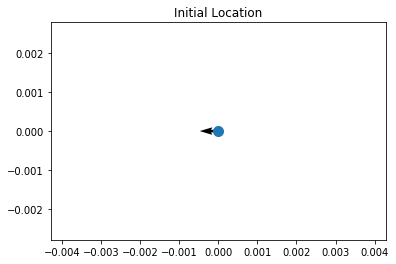

In [121]:
speed_x = np.array(speed_x, dtype = speed.dtype)
speed_y = np.array(speed_y, dtype = speed.dtype)

x = np.matrix([[mx[0], my[0], mz[0], speed_x[0]/3.6, speed_y[0]/3.6, 0.0, 0.0, 0.0]]).T

print(x, x.shape)

U=float(np.cos(x[5])*x[3])
V=float(np.sin(x[5])*x[3])

plt.quiver(x[0], x[1], U, V)
plt.scatter(float(x[0]), float(x[1]), s=100)
plt.title('Initial Location')
plt.axis('equal')

## Initial Uncertainty


In [122]:
P = 1e5*np.eye(numstates)

In [123]:
measurements = np.vstack((mx, my, mz, \
                          speed_x/3.6, \
                          speed_y/3.6, \
                          yaw/180.0*np.pi, \
                          pitch/180.0*np.pi, \
                          roll/180.0*np.pi))

# Lenth of the measurement
m = measurements.shape[1]
print(measurements.shape)

(8, 6014)


In [124]:
# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
x7 = []
x8 = []
Zx = []
Zy = []
P0 = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
P7 = []
P8 = []
K0 = []
K1 = []
K2 = []
K3 = []
K4 = []
K5 = []
K6 = []
K7 = []
dstate=[]

h0 = []
h1 = []
h2 = []

In [125]:

for filterstep in range(m):

    axc = ax[filterstep]
    ayc = ay[filterstep]
    
    yawc = yawrate[filterstep]/180.0*np.pi
    pitc = pitchrate[filterstep]/180.0*np.pi
    rolc = rollrate[filterstep]/180.0*np.pi
    
#     print("old")
#     print(x[0])
#     print(x[1])
#     print(x[2])
    
    if yawc==0.0: # Driving straight
        x[0] = x[0] + x[3]*dt * np.cos(x[5])
        x[1] = x[1] + x[3]*dt * np.sin(x[5]) + x[4]*dt * np.cos(x[7])  
        x[2] = x[2] + x[4]*dt * np.sin(x[7])
        x[3] = x[3] + axc*dt
        x[4] = x[4] + ayc*dt
        x[5] = x[5] + yawc*dt
        x[6] = x[6] + pitc*dt
        x[7] = x[7] + rolc*dt
        yawc = 0.00000001 # to avoid numerical issues in Jacobians
        rolc = 0.00000001 # to avoid numerical issues in Jacobians
        dstate.append(0)
    else: # otherwise
        x[0] = x[0] + (x[3]/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5]))
        x[1] = x[1] + ((x[3]/yawc) * (-np.cos(yawc*dt+x[5])+ np.cos(x[5]))) + ((x[4]/rolc) * (np.sin(rolc*dt+x[7])- np.sin(x[7])))
        x[2] = x[2] + ((x[4]/rolc) * (-np.cos(rolc*dt+x[7])+ np.cos(x[7])))
        x[3] = x[3] + axc*dt
        x[4] = x[4] + ayc*dt
        x[4] = (x[4] + yawc*dt + np.pi) % (2.0*np.pi) - np.pi
        x[5] = x[5] + pitc*dt
        #x[6] = x[6] + rolc*dt
        x[6] = (x[6] + rolc*dt + np.pi) % (2.0*np.pi) - np.pi
        dstate.append(1)
#     print("predicted")
#     print(x[0]) 
#     print(x[1])
#     print(x[2])
    
    
    a14 = float((1.0/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5])))
    a16 = float((x[3]/yawc)* (np.cos(yawc*dt+x[5]) - np.cos(x[5])))
    a24 = float((1.0/yawc) * (-np.cos(yawc*dt+x[5]) + np.cos(x[5])))
    a25 = float((1.0/rolc) * (np.sin(rolc*dt+x[7]) - np.sin(x[7])))
    a26 = float((x[3]/yawc) * (np.sin(yawc*dt+x[5]) - np.sin(x[5])))
    a28 = float((x[4]/rolc)* (np.cos(rolc*dt+x[7]) - np.cos(x[7])))
    a35 = float((1/rolc)* (-np.cos(rolc*dt+x[7]) + np.cos(x[7])))
    a38 = float((x[4]/rolc)* (np.sin(rolc*dt+x[7]) - np.sin(x[7])))

    JA = np.matrix([[1.0, 0.0, 0.0, a14, 0.0, a16, 0.0, 0.0],
                  [0.0, 1.0, 0.0, a24, a25, a26, 0.0, a28],
                  [0.0, 0.0, 1.0, 0.0, a35, 0.0, 0.0, a38],
                  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
    
#     print(np.shape(JA))
    
    
    g13 = float((dt*x[3]/yawc)*np.cos(yawc*dt+x[5]) - (x[3]/yawc**2)*(np.sin(yawc*dt+x[5])-np.sin(x[5])))
    g23 = float((dt*x[3]/yawc)*np.sin(yawc*dt+x[5]) - (x[3]/yawc**2)*(-np.cos(yawc*dt+x[5])+np.cos(x[5])))
    g25 = float((dt*x[4]/rolc)*np.cos(rolc*dt+x[7]) - (x[4]/rolc**2)*(np.sin(rolc*dt+x[7])-np.sin(x[7])))
    g35 = float((dt*x[4]/rolc)*np.sin(rolc*dt+x[7]) - (x[4]/yawc**2)*(-np.cos(rolc*dt+x[7])+np.cos(x[7])))
                
    JG = np.matrix([[0.0, 0.0, g13, 0.0, 0.0],
                    [0.0, 0.0, g23, 0.0, g25],
                    [0.0, 0.0, 0.0, 0.0, g35],
                    [dt, 0.0, 0.0, 0.0, 0.0],
                    [0.0, dt, 0.0, 0.0, 0.0],
                    [0.0, 0.0, dt, 0.0, 0.0],
                    [0.0, 0.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 0.0, dt]])
    
    # Project the error covariance ahead
    P = JA*P*JA.T + JG*Q*JG.T
    
#     print("predicted P")
#     print(P)
    
    
    # Measurement Update (Correction)
    # ===============================
    hx = np.matrix([[float(x[0])],
                    [float(x[1])],
                    [float(x[2])],                    
                    [float(x[3])],
                    [float(x[4])],
                    [float(x[5])],
                    [float(x[6])],
                    [float(x[7])]])
    # Because GPS is sampled with 10Hz and the other Measurements, as well as
    # the filter are sampled with 50Hz, one have to wait for correction until
    # there is a new GPS Measurement
    if GPS[filterstep]:
        #print("GPS")
        # Calculate the Jacobian of the Measurement Function
        # see "Measurement Matrix H"
        JH = np.matrix([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
        S = JH*P*JH.T + R    # R should be small and S should be small 
        K = (P*JH.T) * np.linalg.inv(S)

        # Update the estimate via
        z = measurements[:,filterstep].reshape(JH.shape[0],1)
        y = z - (hx)                         # Innovation or Residual
        x = x + (K*y)

        h0.append(z[0])
        h1.append(z[1])
        h2.append(z[2])

        #     # Update the error covariance
        P = (I - (K*JH))*P



#     else: 
#         JH = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
#                         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])

#     S = JH*P*JH.T + R    # R should be small and S should be small 
#     K = (P*JH.T) * np.linalg.inv(S)

#     # Update the estimate via
#     z = measurements[:,filterstep].reshape(JH.shape[0],1)
#     y = z - (hx)                         # Innovation or Residual
#     x = x + (K*y)

#     h0.append(z[0])
#     h1.append(z[1])
#     h2.append(z[2])

#     #     # Update the error covariance
#     P = (I - (K*JH))*P


#     else:



    

    
# #     # Adaptive R
#     R[0,0] = spx[filterstep]       # x
#     R[1,1] = spy[filterstep]       # y
#     R[2,2] = spy[filterstep]
#     R[3,3] = spspeedx[filterstep]  # vx
#     R[4,4] = spspeedy[filterstep]
#     R[5,5] = syaw[filterstep]  # course
#     R[6,6] = spitch[filterstep]   # pitch
#     R[7,7] = sroll[filterstep]    # roll
    
    

#     print("P")
#     print(P)
#     if GPS[filterstep]:
#         x[0] = measurements[0][filterstep]
#         x[1] = measurements[1][filterstep]
#         x[2] = measurements[2][filterstep]
#         print("corrected")
#         print(x[0])
#         print(x[1])
#         print(x[2])
    
    
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    x6.append(float(x[6]))
    x7.append(float(x[7]))
    P0.append(float(P[0,0]))
    P1.append(float(P[1,1]))
    P2.append(float(P[2,2]))
    P3.append(float(P[3,3]))
    P4.append(float(P[4,4]))
    P5.append(float(P[5,5]))
    P6.append(float(P[6,6]))
    P7.append(float(P[7,7]))
    K0.append(float(K[0,0]))
    K1.append(float(K[1,0]))
    K2.append(float(K[2,0]))
    K3.append(float(K[3,0]))
    K4.append(float(K[4,0]))
    K5.append(float(K[5,0]))
    K6.append(float(K[6,0]))
    K7.append(float(K[7,0]))
    
    
    
    
    

In [126]:
latekf = latitude[0] + np.divide(x1,arc)
lonekf = longitude[0]+ np.divide(x0,np.multiply(arc,np.cos(latitude*np.pi/180.0)))
altekf = altitude[0] + x2


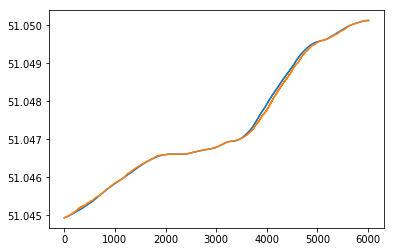

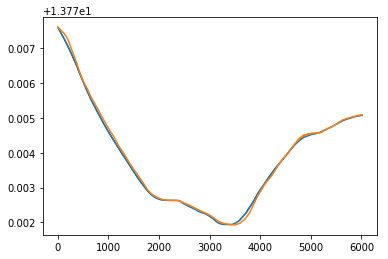

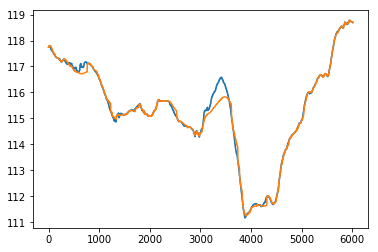

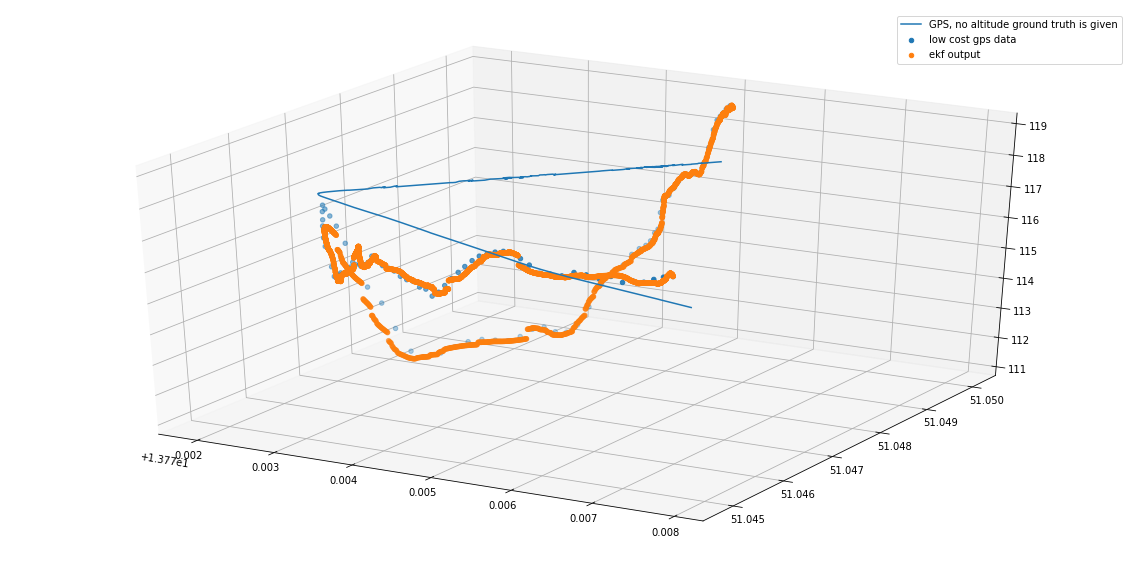

In [135]:


plt.plot(latitude)
plt.plot(latekf)
plt.show()

plt.plot(longitude)
plt.plot(lonekf)
plt.show()

plt.plot(altitude)
plt.plot(altekf)
plt.show()

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Visualize in 3D 

AltDD = (np.zeros(LatDD.shape)+1)*117
mpl.rcParams['legend.fontsize'] = 10
fig = plt.figure(figsize=(20,10))
axpl = fig.gca(projection='3d')
axpl.plot(LonDD, LatDD, AltDD, label='GPS, no altitude ground truth is given' )
axpl.scatter(longitude[::50],latitude[::50],altitude[::50], label = 'low cost gps data')
axpl.scatter(lonekf, latekf, altekf, label = 'ekf output')
axpl.legend()

plt.show()

In [136]:

# fig = plt.figure(figsize=(16,9))
# plt.semilogy(range(m),P0, label='$x$')
# plt.step(range(m),P1, label='$y$')
# plt.step(range(m),P2, label='$z$')
# plt.step(range(m),P3, label='$vx$')
# plt.step(range(m),P4, label='$vy$')
# plt.step(range(m),P5, label='$\psi$')
# plt.step(range(m),P6, label='$\Theta$')
# plt.step(range(m),P7, label='$\phi$')

# plt.xlabel('Filter Step [k]')
# plt.ylabel('')
# plt.xlim(0,6000)
# plt.title('Uncertainty (Elements from Matrix $P$)')
# #plt.legend(loc='best',prop={'size':22})
# plt.legend(bbox_to_anchor=(0., 0.91, 1., .06), loc=3,
#        ncol=9, mode="expand", borderaxespad=0.,prop={'size':22})
# plt.savefig('Covariance-Matrix-Verlauf.eps', bbox_inches='tight')